In [ ]:
# !kaggle datasets download -d tuannguyenvananh/image-6-class-dataset
# import zipfile
# zip_ref = zipfile.ZipFile('/content/image-6-class-dataset.zip', 'r')
# zip_ref.extractall('/content')
# zip_ref.close()

In [14]:
import os
for dirpath,dirnames,filenames in os.walk("data"):
    print(f" There are {len(dirnames)} directories and {len(filenames)} images in {dirpath} ")

 There are 2 directories and 0 images in data 
 There are 6 directories and 0 images in data\test_set 
 There are 0 directories and 437 images in data\test_set\buildings 
 There are 0 directories and 474 images in data\test_set\forest 
 There are 0 directories and 553 images in data\test_set\glacier 
 There are 0 directories and 525 images in data\test_set\mountain 
 There are 0 directories and 510 images in data\test_set\sea 
 There are 0 directories and 501 images in data\test_set\street 
 There are 6 directories and 0 images in data\training_set 
 There are 0 directories and 2191 images in data\training_set\buildings 
 There are 0 directories and 2271 images in data\training_set\forest 
 There are 0 directories and 2404 images in data\training_set\glacier 
 There are 0 directories and 2512 images in data\training_set\mountain 
 There are 0 directories and 2274 images in data\training_set\sea 
 There are 0 directories and 2382 images in data\training_set\street 


In [15]:
train_dir = "./data/training_set/"
test_dir = "./data/test_set/"

In [16]:
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted(item.name for item in data_dir.glob("*")))
class_names = class_names[1:]
class_names

array(['forest', 'glacier', 'mountain', 'sea', 'street'], dtype='<U9')

In [17]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
def view_random_image(target_dir,target_class):
    target_folder = target_dir+target_class
    print(target_folder)
    random_image = random.sample(os.listdir(target_folder), 1)
    print(f" this is {random_image}")
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)  # Use plt.imshow instead of plt.show
    plt.title(target_class)
    plt.axis("off")
    print(f"Image shape: {img.shape}")
    plt.show()  # Call plt.show() after setting up the plot

    return img
    

./data/training_set/forest
 this is ['3396.jpg']
Image shape: (150, 150, 3)


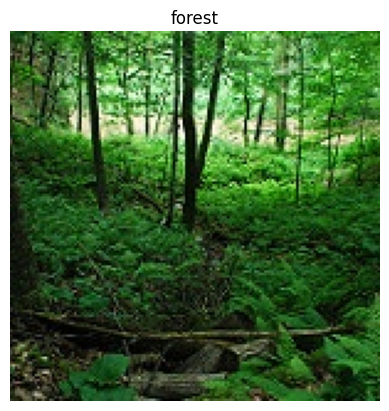

In [18]:
import random
img = view_random_image(target_dir=train_dir,target_class=random.choice(class_names))

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator as ig
train_datagen = ig(rescale=1/255.,
                  rotation_range=0.3,
                  width_shift_range=0.3,
                  height_shift_range=0.4,
                  zoom_range=0.2,
                  horizontal_flip=True)
test_datagen = ig(1/255.)
train_data = train_datagen.flow_from_directory(train_dir,
                                              target_size = (224,224),
                                              batch_size = 32,
                                              class_mode = "categorical")
test_data = test_datagen.flow_from_directory(test_dir,
                                            target_size = (224,224),
                                            batch_size=32,
                                            class_mode = "categorical")

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPool2D, Conv2D, Dense, Flatten

In [21]:
image_class_model = Sequential([
    Conv2D(10, 3, input_shape=(224, 224, 3), activation="relu"),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Conv2D(10, 3, activation="relu"),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(32, activation="relu"),
    Dense(6, activation="softmax")
])

image_class_model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),  # Updated to non-legacy version
    metrics=["accuracy"]
)

C:\Users\HP5CD\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
with tf.device('/CPU:0'):
    history = image_class_model.fit(train_data,
                               epochs=5,
                               steps_per_epoch=len(train_data),
                               validation_data=test_data,
                               validation_steps=len(test_data))

Epoch 1/5
 67/439 ━━━━━━━━━━━━━━━━━━━━ 2:02 330ms/step - accuracy: 0.2120 - loss: 1.8419

KeyboardInterrupt: 

In [ ]:
def plot_loss_curves(history):
    loss=history.history["loss"]
    val_loss = history.history["val_loss"]
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs = range(len(history.history["loss"]))
    plt.plot(epochs,loss,label="training_loss")
    plt.plot(epochs,val_loss,label="val_LOSS")
    plt.title("accuracy")
    plt.xlabel("epochs")
    plt.legend()
    #plot the accuracy
    plt.figure()
    plt.plot(epochs,accuracy,label="training_accuracy")
    plt.plot(epochs,val_accuracy,label="val_accuracy")
    plt.title("accuracy")
    plt.xlabel("epochs")
    plt.legend()

In [ ]:
plot_loss_curves(history)

In [ ]:
image_class_model.save("6_class_image.h5")


In [ ]:
load_image_model = tf.keras.models.load_model("6_class_image.h5")

In [ ]:
def load_and_prep_image(filename,img_shape=224):
    
    img = tf.io.read_file(filename)
    
    img = tf.image.decode_image(img)
    img = tf.image.resize(img,size = [img_shape,img_shape])
   
    
    
    img = img/255.
    return img

In [ ]:
def pred_and_plot(model,filename,class_names=class_names):
    img = load_and_prep_image(filename)
    pred = model.predict(tf.expand_dims(img,axis=0)) 
    if len(pred[0])>1:
        pred_class = class_names[tf.argmax(pred[0])]
    else:
        pred_class = class_names[int(tf.round(pred))]
    plt.imshow(img)
    plt.title(f"Prediction : {pred_class}")
    plt.axis(False)

2023-11-23 09:56:53.073574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 448ms/step


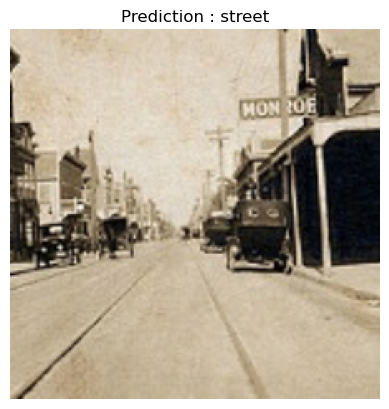

In [ ]:
pred_and_plot(model=load_image_model,filename="archive-4/seg_pred/seg_pred/14.jpg",class_names=class_names)

In [ ]:
pip install scipy


  Using cached scipy-1.13.0-cp310-cp310-win_amd64.whl.metadata (60 kB)
Using cached scipy-1.13.0-cp310-cp310-win_amd64.whl (46.2 MB)
Note: you may need to restart the kernel to use updated packages.
